In [18]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from utils.augmentations import frequency_augmentation, time_augmentation
from utils.dataset import TFC_Dataset
from utils.models import TFC_encoder, ContrastiveLoss
from torch.optim import Adam

In [2]:
path = 'datasets/ECG/'
train = torch.load(path + 'train.pt')
val = torch.load(path + 'val.pt')
test = torch.load(path + 'test.pt')

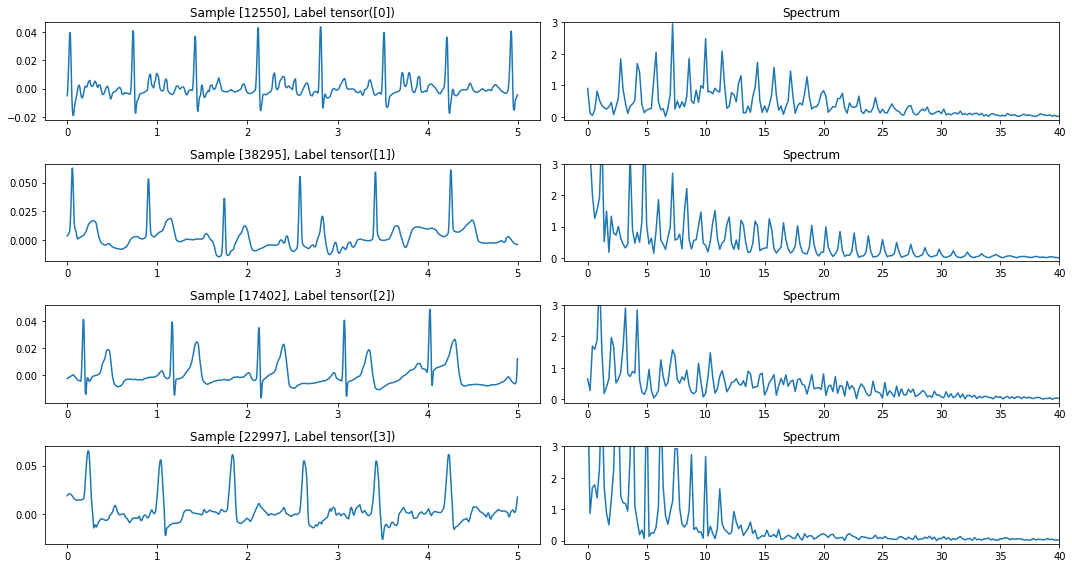

In [3]:
idx = []

for lab in range(4):
    id = np.random.choice(np.where(train['labels'] == lab)[0], 1)
    idx.append(id)

fig1, ax1 = plt.subplots(4, 2, figsize = (15,8))

#fig2, ax2 = plt.subplots(4, 2, figsize = (15,8))
freqs = np.fft.rfftfreq(1500, d = 1/300)
time = np.arange(1500)/300

for j, id in enumerate(idx):
    samp = train['samples'][id,0,:].squeeze()
    label = train['labels'][id]
    ax1[j, 0].plot(time, samp)
    ax1[j, 0].set_title('Sample {}, Label {}'.format(id, label))
    fft = np.fft.rfft(samp)
    ax1[j, 1].plot(freqs, abs(fft))
    ax1[j, 1].set_title('Spectrum'.format(id, label))
    ax1[j,1].set_xlim([-2,40])
    ax1[j,1].set_ylim([-0.1,3])
        
plt.tight_layout()
plt.show()


In [4]:
x = train['samples']

In [5]:
n_samples = 3
# Examine augmentations
idx = np.random.choice(np.arange(len(x)), n_samples)

freq_cont = torch.fft.fft(x[idx], axis = -1)
freq_aug, time_freq_aug = frequency_augmentation(freq_cont)
time_aug, freq_time_aug = time_augmentation(x[idx], keep_all = True)

/Users/theb/Documents/PhD/code/self-supervision/utils/augmentations.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_sig = np.concatenate(np.random.permutation(sig_split), axis = 0)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


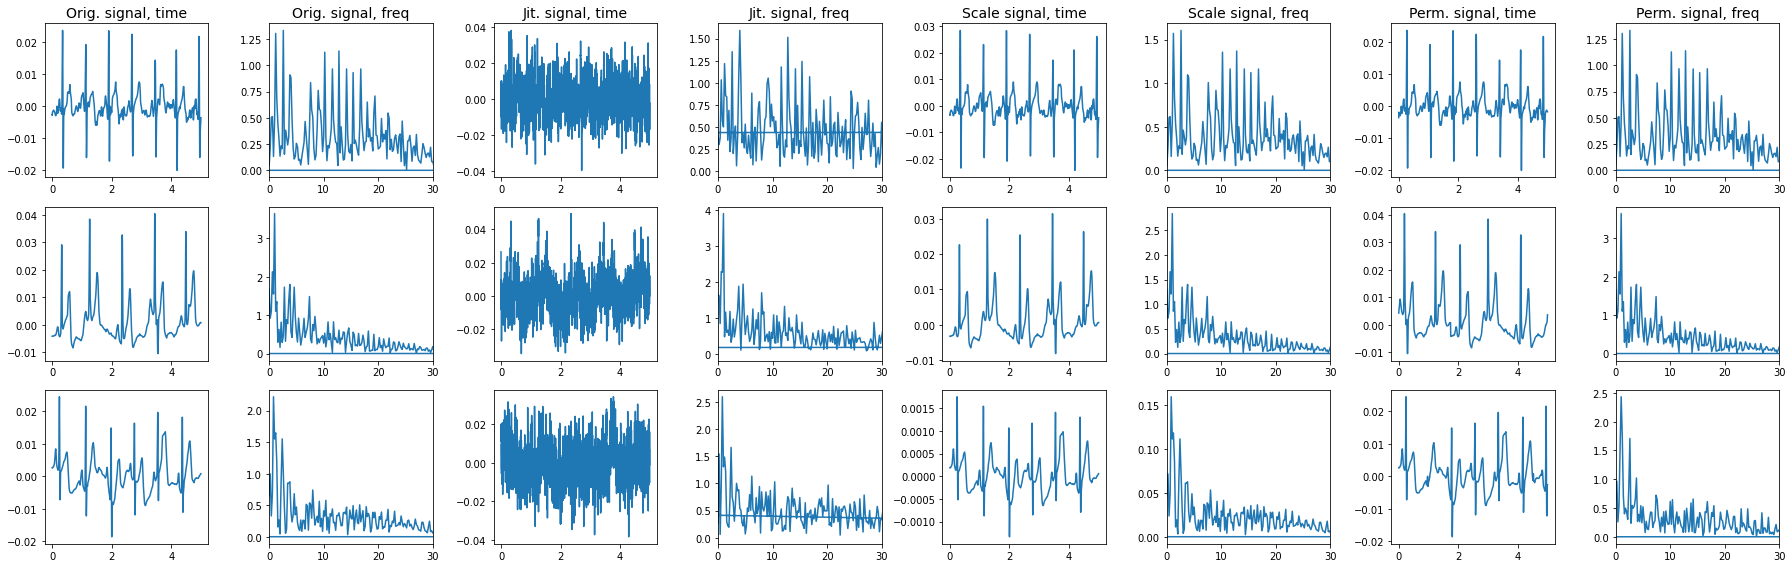

In [6]:
# Examine augmentations
fig, axes = plt.subplots(nrows= n_samples, ncols = 8, figsize=(25, 8))
time = np.arange(1500)/300
freq = np.fft.fftfreq(1500, 1/300)
augmentations = ['Orig. signal, time', 'Orig. signal, freq', 'Jit. signal, time', 'Jit. signal, freq', 'Scale signal, time', 'Scale signal, freq', 'Perm. signal, time', 'Perm. signal, freq']

for i, row in enumerate(axes):
    for j in range(0, len(row), 2):
        for k in range(2):
            ax = row[j+k]
            if i == 0:
                ax.set_title(augmentations[j+k], fontsize = 14)
            if k == 0:
                ax.plot(time, time_aug[i,int(j/2),0,:])
            else:
                ax.plot(freq, freq_time_aug[i,int(j/2),0,:])
                ax.set_xlim([0, 30])

plt.tight_layout()
plt.show()

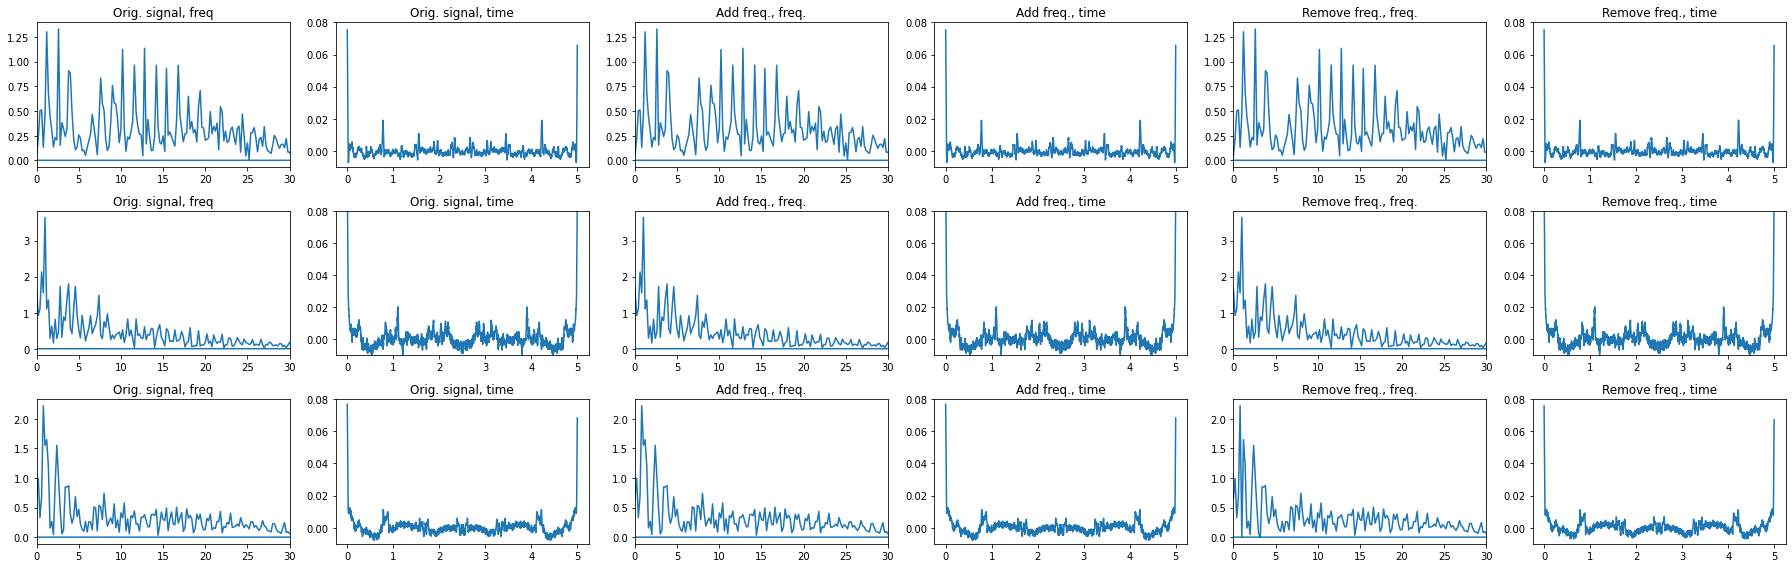

In [7]:
# Examine augmentations
fig, axes = plt.subplots(nrows= n_samples, ncols = 6, figsize=(25, 8))
time = np.arange(1500)/300
freq = np.fft.fftfreq(1500, 1/300)
augmentations = ['Orig. signal, freq', 'Orig. signal, time', 'Add freq., freq.', 'Add freq., time', 'Remove freq., freq.', 'Remove freq., time']

for i, row in enumerate(axes):
    for j in range(0, len(row), 2):
        for k in range(2):
            ax = row[j+k]
            ax.set_title(augmentations[j+k])
            if k == 0:
                ax.plot(freq, freq_aug[i,int(j/2),0,:])
                ax.set_xlim([0, 30])
            else:
                ax.plot(time, time_freq_aug[i,int(j/2),0,:])
                ax.set_ylim([-0.01, 0.08])

plt.tight_layout()
plt.show()

In [8]:
TFC_dset = TFC_Dataset(train['samples'], train['labels'])
train_loader = DataLoader(TFC_dset, batch_size = 64, shuffle = True, drop_last=True)

/Users/theb/Documents/PhD/code/self-supervision/utils/augmentations.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_sig = np.concatenate(np.random.permutation(sig_split), axis = 0)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
val_dset = TensorDataset(val['samples'], val['labels'])

In [9]:
out = TFC_dset.__getitem__(0)

In [10]:
temp = next(iter(train_loader))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = ContrastiveLoss(tau = 0.2, batchsize=64, device = device)

model = TFC_encoder(in_channels = 1, input_size = 1500, num_classes = 4, classify = True).to(device)
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)

In [12]:
epochs = 2
time_loss_total = []
freq_loss_total = []
time_freq_loss_total = []
loss_total = []
lambda_ = 0.5 
delta_ = 1

for epoch in range(epochs):
    epoch_time, epoch_freq, epoch_time_freq, epoch_loss = [0, 0, 0, 0]
    for i, (x_t, x_f, x_t_aug, x_f_aug, y) in enumerate(train_loader):
        x_t, x_f, x_t_aug, x_f_aug, y = x_t.float().to(device), x_f.float().to(device), x_t_aug.float().to(device), x_f_aug.float().to(device), y.float().to_device()

        h_t, z_t, h_f, z_f, out = model(x_t, x_f)
        h_t_aug, z_t_aug, h_f_aug, z_f_aug, _ = model(x_t_aug, x_f_aug)

        time_loss = loss_fn(h_t, h_t_aug)
        freq_loss = loss_fn(h_f, h_f_aug)

        time_freq_pos = loss_fn(z_t, z_f)
        time_freq_neg  = loss_fn(z_t, z_f_aug), loss_fn(z_t_aug, z_f), loss_fn(z_t_aug, z_f_aug)
        loss_TFC = 3*time_freq_pos - time_freq_neg[0] - time_freq_neg[1] - time_freq_neg[2] + 3*delta_

        loss = lambda_*(time_loss + freq_loss) + (1-lambda_)*loss_TFC

        epoch_time += time_loss.detach().cpu()
        epoch_freq += freq_loss.detach().cpu()
        epoch_time_freq += loss_TFC.detach().cpu()
        epoch_loss += loss.detach().cpu()

        loss.backward()
        optimizer.step()
        
    time_loss_total.append(epoch_time)
    freq_loss_total.append(epoch_freq)
    time_freq_loss_total.append(epoch_time_freq)
    loss_total.append(epoch_loss)




1 of 2
0 of 682
1 of 682
2 of 682
3 of 682
4 of 682


KeyboardInterrupt: 